In [15]:
import os
import re
import time
import numpy as np
from scipy import io
from tqdm import tqdm
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
INPUT_DIRS = [
    '/datasets/kaggle/mls/train_1',
    '/datasets/kaggle/mls/train_2',
    '/datasets/kaggle/mls/train_3',
    '/datasets/kaggle/mls/test_1',
    '/datasets/kaggle/mls/test_2',
    '/datasets/kaggle/mls/test_3'
]

OUTPUT_DIRS = {
    'waveforms': 'out/waveforms',
    'cache': 'out/'
}

N_SAMPLES = 240000
SAMPLING_RATE = 400
N_CHANNELS = 16

In [17]:
# make sure output dirs exist
for v in OUTPUT_DIRS.values(): 
    if not os.path.isdir(v): 
        os.makedirs(v)

In [18]:
# list files in directories
def list_files(src_dirs):

    if not list == type(src_dirs): src_dirs = [src_dirs]
    
    f = []
    
    for d in src_dirs:
        df = []
        for (dirpath, dirnames, filenames) in os.walk(d):
            filenames = [dirpath + '/' + x for x in filenames]
            df.extend(filenames)
        f.extend(df)
    
    return f

In [19]:
def read_mat(f):
    mat = io.loadmat(f)
    
    sampling_rate = int(mat['dataStruct'][0, 0][1][0, 0])
    n_samples = int(mat['dataStruct'][0, 0][2][0, 0])
    ch_indexes = np.int8(mat['dataStruct'][0, 0][3][0])
    
    # make sure all files have the same format
    assert(sampling_rate == SAMPLING_RATE)
    assert(n_samples == N_SAMPLES)
    assert(len(ch_indexes) == N_CHANNELS)
    
    data = mat['dataStruct'][0, 0][0].T
    
    waves = np.zeros([len(ch_indexes), n_samples], dtype=np.float32)
    
    for i in range(len(ch_indexes)):
        waves[i] = data[ch_indexes[i] - 1]  
        
    return waves

In [20]:
def compute_metrics():
    n_waves = 0
    avg_wave = np.zeros(N_SAMPLES, dtype=np.float32)
    maxs = []
    mins = []

    for f in tqdm(list_files(INPUT_DIRS)):
        n_waves += 1
        waves = read_mat(f)
        
        # mins/maxs
        maxs.append(np.max(waves, axis=1))
        mins.append(np.min(waves, axis=1))
        
        # mean, median
        
        # compute avg wave
        cur_avg_wave = np.divide(np.sum(waves, axis=0), len(waves))
        sum_all_waves = np.sum((np.multiply(avg_wave, n_waves - 1), cur_avg_wave), axis=0)
        avg_wave = np.divide(sum_all_waves, n_waves)
        
    return np.array(mins, dtype=np.float32),\
        np.array(maxs, dtype=np.float32),\
        avg_wave

In [21]:
metrics_file = OUTPUT_DIRS['cache'] + '/metrics.npy'

In [22]:
if not os.path.isfile(metrics_file):
    print 'Gathering metrics...'; time.sleep(0.5)
    mins, maxs, avg_wave = compute_metrics()
    np.save(OUTPUT_DIRS['cache'] + '/metrics.npy', {'mins': mins, 'maxs': maxs, 'avg': avg_wave})

In [23]:
metrics = np.load(metrics_file).item()

# compute thresholds for 99% of mins/maxs
max_threshold = np.percentile(metrics['maxs'], 95)
min_threshold = -np.percentile(np.abs(metrics['mins']), 95)
avg_wave = metrics['avg']

In [24]:
max_threshold

501.91470794677718

In [25]:
min_threshold

-917.95163574218748

In [27]:
# process waveforms

print 'Processing waveforms...'; time.sleep(0.5)

scale_factor = max(max_threshold, abs(min_threshold))

for f in tqdm(list_files(INPUT_DIRS)):
    fid = re.findall(r'([\d_]+)\.mat$', f)[0]
    waves = read_mat(f)
    
    break

    # subtract mean
    waves = np.subtract(waves, avg_wave)
    # clip
    waves = np.clip(waves, min_threshold, max_threshold)
    # scale
    waves = np.divide(waves, scale_factor)
    
    # save
    out_f = OUTPUT_DIRS['waveforms'] + '/' + fid
    np.save(out_f, waves)

Processing waveforms...


  0%|          | 0/12168 [00:00<?, ?it/s]


In [31]:
w = waves[0]
w = np.subtract(w, avg_wave)


In [50]:
ma = np.max(waves, axis=1)
mi = np.min(waves, axis=1)

In [51]:
scale = np.max([np.abs(ma), np.abs(mi)], axis=0)

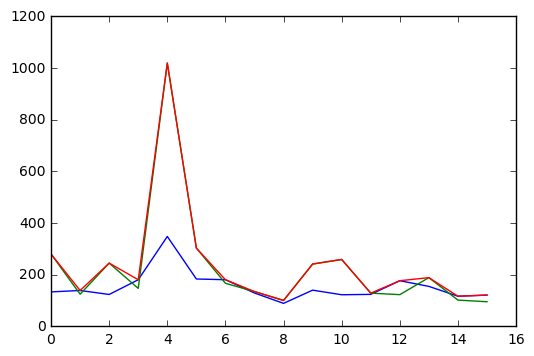

In [53]:
plt.plot(ma)
plt.plot(np.abs(mi))
plt.plot(scale)

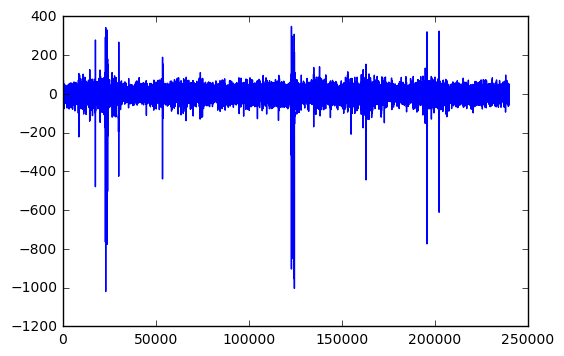

In [ ]:
import